# Neural Nets Final Project

## Initialize Notebook Essentials

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
import h5py
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
import time
import torchvision
import torchvision.transforms as transforms
from PIL import Image

In [2]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Import Metastatic Tissue Dataset

In [3]:
training_num = 50000
testing_num = 5000
val_num = 5000

In [4]:
#load the data
def load_data(filename):
    with h5py.File(filename, "r") as f:
        # List all groups
        a_group_key = list(f.keys())[0]

        # Get the data
        data = torch.from_numpy(f[a_group_key][:])
        return data
    
training_images = load_data("./pcam/training_split.h5")
print(training_images.shape)

validation_split = load_data("./pcam/validation_split.h5")
test_split = load_data("./pcam/test_split.h5")

validation_labels = load_data("./Labels/Labels/camelyonpatch_level_2_split_valid_y.h5").squeeze().type(torch.LongTensor)
testing_labels = load_data("./Labels/Labels/camelyonpatch_level_2_split_test_y.h5").squeeze().type(torch.LongTensor)
training_labels = load_data("./Labels/Labels/camelyonpatch_level_2_split_train_y.h5").squeeze().type(torch.LongTensor)
print(training_labels.shape)

torch.Size([262144, 96, 96, 3])
torch.Size([262144])


In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, image, labels):
        self.labels = labels
        self.image = image
    def __len__(self):
            return len(self.labels)
    def __getitem__(self, index):
            label = self.labels[index]
            images = self.image[index]
            sample = {"Image": images, "Label": label}
            return (images,label)

1


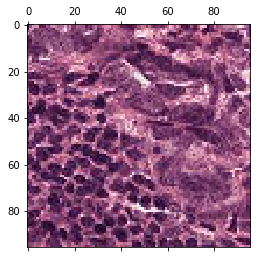

In [6]:
print(training_labels[56].item())
plt.matshow(training_images[56])

0


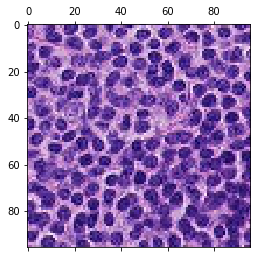

In [7]:
print(training_labels[5].item())
plt.matshow(training_images[5])

In [8]:
training_images = training_images[:training_num]
training_labels = training_labels[:training_num]
print("TRAINING DATA")
print("Label counts:", training_labels.unique(return_counts = True))
training_images = training_images.permute((0,3,1,2)).type(torch.FloatTensor)
print("Shape:", training_images.shape)

TRAINING DATA
Label counts: (tensor([0, 1]), tensor([24934, 25066]))
Shape: torch.Size([50000, 3, 96, 96])


In [9]:
validation_split = validation_split[:val_num]
validation_labels = validation_labels[:val_num]
print("VALIDATION DATA")
print("Label counts:", validation_labels.unique(return_counts = True))
validation_split = validation_split.permute((0,3,1,2)).type(torch.FloatTensor)
print("Shape:", validation_split.shape)

VALIDATION DATA
Label counts: (tensor([0, 1]), tensor([2468, 2532]))
Shape: torch.Size([5000, 3, 96, 96])


In [10]:
test_split = test_split[:testing_num]
testing_labels = testing_labels[:testing_num]
print("TESTING DATA")
print("Label counts:", testing_labels.unique(return_counts = True))
test_split = test_split.permute((0,3,1,2)).type(torch.FloatTensor)
print("Shape:", test_split.shape)

TESTING DATA
Label counts: (tensor([0, 1]), tensor([2464, 2536]))
Shape: torch.Size([5000, 3, 96, 96])


In [11]:
TrainingData = CustomImageDataset(training_images ,training_labels)
TestData = CustomImageDataset(test_split,testing_labels)
ValData = CustomImageDataset(validation_split,validation_labels)

## Train TissueCNN Model

In [12]:
# Doing batching
batch_size = 256
train_loader = torch.utils.data.DataLoader(TrainingData, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(TestData, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ValData, batch_size, shuffle=True)

In [13]:
class TissueCNN(nn.Module):
    def __init__(self, num_channels = 3):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=10, kernel_size = (4,4)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size = (4,4)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),
            nn.Conv2d(in_channels=20, out_channels=30, kernel_size = (4,4)),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Flatten(1),
            nn.Linear(8670, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [14]:
def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        total_loss = 0
        for epoch in tqdm(range(nepoch)):
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                outputs = outputs.squeeze()
                loss = criterion(outputs, labels.type(torch.FloatTensor))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            if not epoch % 1:
                print("EPOCH", epoch)
                print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/(epoch + 1)))
                with torch.no_grad():
                    correct = 0
                    total = 0
                    total_loss = 0
                    true, pred = [], []
                    # validate with validation set
                    for val_inputs, val_labels in val_loader:
                        outputs = model(val_inputs)
                        predicted = (outputs > .5).float().squeeze()
                        total += val_labels.size(0)
                        total_loss += criterion(outputs.squeeze(), val_labels.type(torch.FloatTensor))
                        correct += (predicted == val_labels).sum().item()
#                         true.append(val_labels)
#                         pred.append(predicted) 
                    print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/10))
                    val_accuracy = (100 * correct / total)
                    print('Val accuracy: %0.3f' % (100 * correct / total))
#                     if val_accuracy > 79:
#                         return 
                    print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

In [15]:
def test_network(model, test_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        true, pred = [], []
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > .5).float().squeeze()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted) 
        accuracy = 100 * correct / total
        print('Test accuracy: %0.3f' % accuracy)
        return accuracy

In [16]:
# Initialize model
model = TissueCNN()
print(model)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

TissueCNN(
  (layers): Sequential(
    (0): Conv2d(3, 10, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(20, 30, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8670, out_features=1, bias=True)
    (11): Sigmoid()
  )
)


In [17]:
epochs = 15
train_network(model, train_loader, val_loader, criterion, optimizer, epochs)

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 249.48234
   Val loss: 1.07384
Val accuracy: 74.300

EPOCH 1
 Train loss: 56.03526
   Val loss: 1.01672
Val accuracy: 76.460

EPOCH 2
 Train loss: 35.69121
   Val loss: 0.98693
Val accuracy: 76.760

EPOCH 3
 Train loss: 26.16227
   Val loss: 0.98836
Val accuracy: 76.680

EPOCH 4
 Train loss: 20.65235
   Val loss: 0.96136
Val accuracy: 77.780

EPOCH 5
 Train loss: 16.96185
   Val loss: 0.96014
Val accuracy: 77.840

EPOCH 6
 Train loss: 14.37219
   Val loss: 1.00610
Val accuracy: 76.000

EPOCH 7
 Train loss: 12.52552
   Val loss: 0.97222
Val accuracy: 77.620

EPOCH 8
 Train loss: 11.00989
   Val loss: 0.95899
Val accuracy: 78.640

EPOCH 9
 Train loss: 9.84211
   Val loss: 0.94337
Val accuracy: 78.820

EPOCH 10
 Train loss: 8.86508
   Val loss: 0.93508
Val accuracy: 78.820

EPOCH 11
 Train loss: 8.08689
   Val loss: 0.94786
Val accuracy: 78.320

EPOCH 12
 Train loss: 7.36696
   Val loss: 0.93745
Val accuracy: 78.860

EPOCH 13
 Train loss: 6.86841
   Val loss: 0.91359


In [19]:
orig_acc = test_network(model, test_loader)

Test accuracy: 79.200


## Experiment 1: Grayscale

### Prepare Data

In [20]:
#If you organize the data like this, it shouldn't crash our computers lol
grayscale = torchvision.transforms.Grayscale(3)

start = time.time()
training_labels = load_data("./Labels/Labels/camelyonpatch_level_2_split_train_y.h5").squeeze().type(torch.LongTensor)
training_labels = training_labels[:training_num]
training_images = load_data("./pcam/training_split.h5")
training_images = training_images[:training_num]
training_images = training_images.permute((0,3,1,2)).type(torch.FloatTensor)
training_images = grayscale(training_images)
GrayscaleTrainingData = CustomImageDataset(training_images ,training_labels)
end = time.time()
print("Training Data build time: %0.3f" % (end-start))

start = time.time()
validation_labels = load_data("./Labels/Labels/camelyonpatch_level_2_split_valid_y.h5").squeeze().type(torch.LongTensor)
validation_labels = validation_labels[:val_num]
validation_split = load_data("./pcam/validation_split.h5")
validation_split = validation_split[:val_num]
validation_split = validation_split.permute((0,3,1,2)).type(torch.FloatTensor)
validation_split = grayscale(validation_split)
GrayscaleValData = CustomImageDataset(validation_split,validation_labels)
end = time.time()
print("Validation Data build time: %0.3f" % (end-start))

start = time.time()
testing_labels = load_data("./Labels/Labels/camelyonpatch_level_2_split_test_y.h5").squeeze().type(torch.LongTensor)
testing_labels = testing_labels[:testing_num]
test_split = load_data("./pcam/test_split.h5")
test_split = test_split[:testing_num]
test_split = test_split.permute((0,3,1,2)).type(torch.FloatTensor)
test_split = grayscale(test_split)
GrayscaleTestData = CustomImageDataset(test_split,testing_labels)
end = time.time()
print("Testing Data build time: %0.3f" % (end-start))

Training Data build time: 16.192
Validation Data build time: 0.730
Testing Data build time: 0.678


In [21]:
##Doing batching
batch_size = 64
grayscale_train_loader = torch.utils.data.DataLoader(GrayscaleTrainingData, batch_size, shuffle=True)
grayscale_val_loader = torch.utils.data.DataLoader(GrayscaleTestData, batch_size, shuffle=True)
grayscale_test_loader = torch.utils.data.DataLoader(GrayscaleValData, batch_size, shuffle=True)

### Show Grayscale Images

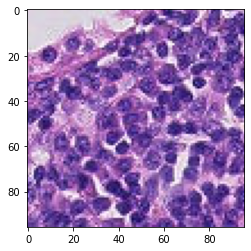

In [22]:
plt.imshow(TrainingData[0][0].permute(1,2,0).type(torch.LongTensor))

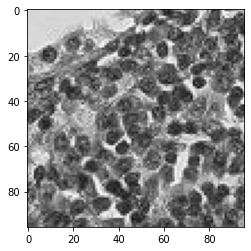

In [23]:
plt.imshow(GrayscaleTrainingData[0][0].permute(1,2,0).type(torch.LongTensor))

### Train Grayscale Model

In [25]:
grayscale_model = TissueCNN()
print(grayscale_model)
criterion = nn.BCELoss()
grayscale_optimizer = torch.optim.Adam(grayscale_model.parameters(), lr=0.00005)

TissueCNN(
  (layers): Sequential(
    (0): Conv2d(3, 10, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(20, 30, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8670, out_features=1, bias=True)
    (11): Sigmoid()
  )
)


In [26]:
epochs = 15
train_network(grayscale_model, grayscale_train_loader, grayscale_val_loader, criterion, grayscale_optimizer, epochs)

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 537.78203
   Val loss: 4.57437
Val accuracy: 71.000

EPOCH 1
 Train loss: 215.24342
   Val loss: 3.92814
Val accuracy: 77.860

EPOCH 2
 Train loss: 136.64717
   Val loss: 3.82170
Val accuracy: 77.700

EPOCH 3
 Train loss: 100.28352
   Val loss: 3.75252
Val accuracy: 78.500

EPOCH 4
 Train loss: 78.63493
   Val loss: 3.76297
Val accuracy: 78.240

EPOCH 5
 Train loss: 64.61404
   Val loss: 4.15567
Val accuracy: 74.120

EPOCH 6
 Train loss: 54.94022
   Val loss: 3.91407
Val accuracy: 75.820

EPOCH 7
 Train loss: 47.47591
   Val loss: 3.67879
Val accuracy: 78.420

EPOCH 8
 Train loss: 41.35331
   Val loss: 3.73951
Val accuracy: 79.280

EPOCH 9
 Train loss: 36.69386
   Val loss: 3.69784
Val accuracy: 79.360

EPOCH 10
 Train loss: 33.09250
   Val loss: 3.74926
Val accuracy: 77.420

EPOCH 11
 Train loss: 30.08282
   Val loss: 4.05897
Val accuracy: 74.680

EPOCH 12
 Train loss: 27.60417
   Val loss: 3.64733
Val accuracy: 79.740

EPOCH 13
 Train loss: 25.19005
   Val loss: 

In [27]:
grayscale_acc = test_network(grayscale_model, grayscale_test_loader)

Test accuracy: 79.060


In [30]:
### GrayScale Results

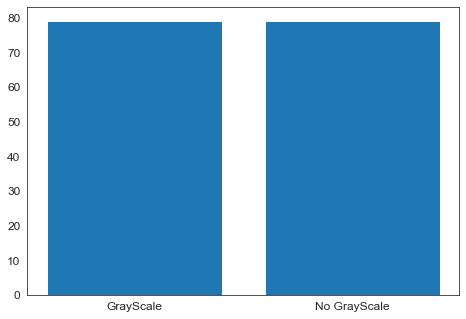

GrayScale Accuracy: 79.06
No GrayScale Accuracy: 79.2


In [49]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
types = ['GrayScale', 'No GrayScale']
acc = [grayscale_acc, orig_acc]
ax.bar(types,acc)
plt.show()

print("GrayScale Accuracy: " + str(grayscale_acc))
print("No GrayScale Accuracy: " + str(orig_acc))

## Experiment 2: Perimeter Masking

In [28]:
# negate the 32 pixels on all sides of the image
def negateContext(img, num_pixels = 32): # assumes a 3 x 96 x 96 image
    top_end = num_pixels
    bottom_start = 96 - num_pixels
    for i in range(3):
        img[i][:top_end] = 0
        img[i][bottom_start:] = 0
        for j in range(top_end, bottom_start):
            img[i][j][:top_end] = 0
            img[i][j][bottom_start:] = 0

#negate the images contained in the data
def negateContextOfData(data, num_pixels = 32):
    for img in data:
        negateContext(img, num_pixels)

### Crop Data

In [27]:
#If you organize the data like this, it shouldn't crash our computers lol
start = time.time()
training_labels = load_data("./Labels/Labels/camelyonpatch_level_2_split_train_y.h5").squeeze().type(torch.LongTensor)
training_labels = training_labels[:training_num]
training_images = load_data("./pcam/training_split.h5")
training_images = training_images[:training_num]
training_images = training_images.permute((0,3,1,2)).type(torch.FloatTensor)
negateContextOfData(training_images)
CroppedTrainingData = CustomImageDataset(training_images ,training_labels)
end = time.time()
print("Training Data build time: %0.3f" % (end-start))

start = time.time()
validation_labels = load_data("./Labels/Labels/camelyonpatch_level_2_split_valid_y.h5").squeeze().type(torch.LongTensor)
validation_labels = validation_labels[:val_num]
validation_split = load_data("./pcam/validation_split.h5")
validation_split = validation_split[:val_num]
validation_split = validation_split.permute((0,3,1,2)).type(torch.FloatTensor)
negateContextOfData(validation_split)
CroppedValData = CustomImageDataset(validation_split,validation_labels)
end = time.time()
print("Validation Data build time: %0.3f" % (end-start))

start = time.time()
testing_labels = load_data("./Labels/Labels/camelyonpatch_level_2_split_test_y.h5").squeeze().type(torch.LongTensor)
testing_labels = testing_labels[:testing_num]
test_split = load_data("./pcam/test_split.h5")
test_split = test_split[:testing_num]
test_split = test_split.permute((0,3,1,2)).type(torch.FloatTensor)
negateContextOfData(test_split)
CroppedTestData = CustomImageDataset(test_split,testing_labels)
end = time.time()
print("Testing Data build time: %0.3f" % (end-start))

Training Data build time: 93.540
Validation Data build time: 8.536
Testing Data build time: 8.501


In [28]:
#Batching Cropped Data
batch_size = 256
cropped_train_loader = torch.utils.data.DataLoader(CroppedTrainingData, batch_size, shuffle=True)
cropped_val_loader = torch.utils.data.DataLoader(CroppedTestData, batch_size, shuffle=True)
cropped_test_loader = torch.utils.data.DataLoader(CroppedValData, batch_size, shuffle=True)

### Show Cropped Images

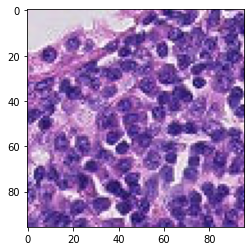

In [29]:
plt.imshow(TrainingData[0][0].permute(1,2,0).type(torch.LongTensor))

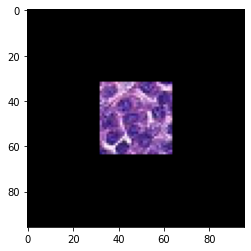

In [30]:
plt.imshow(CroppedTrainingData[0][0].permute(1,2,0).type(torch.LongTensor))

### Test Uncropped-Trained Model

In [31]:
unc_model_cropped = test_network(model, cropped_test_loader)

Test accuracy: 49.380


In [32]:
unc_model_uncropped = test_network(model, test_loader)

Test accuracy: 79.160


### Train Cropped Model

In [33]:
# Initialize model
cropped_model = TissueCNN()
print(cropped_model)
criterion = nn.BCELoss()
cropped_optimizer = torch.optim.Adam(cropped_model.parameters(), lr=0.00005)

TissueCNN(
  (layers): Sequential(
    (0): Conv2d(3, 10, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(20, 30, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8670, out_features=1, bias=True)
    (11): Sigmoid()
  )
)


In [34]:
epochs = 15
train_network(cropped_model, cropped_train_loader, cropped_val_loader, criterion, cropped_optimizer, epochs)

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 145.22456
   Val loss: 1.23126
Val accuracy: 67.160

EPOCH 1
 Train loss: 63.01882
   Val loss: 1.18844
Val accuracy: 70.900

EPOCH 2
 Train loss: 39.66214
   Val loss: 1.13767
Val accuracy: 72.540

EPOCH 3
 Train loss: 28.87188
   Val loss: 1.07630
Val accuracy: 73.720

EPOCH 4
 Train loss: 22.58434
   Val loss: 1.05772
Val accuracy: 74.240

EPOCH 5
 Train loss: 18.58420
   Val loss: 1.07259
Val accuracy: 74.480

EPOCH 6
 Train loss: 15.81394
   Val loss: 1.08398
Val accuracy: 74.600

EPOCH 7
 Train loss: 13.79120
   Val loss: 1.07968
Val accuracy: 74.480

EPOCH 8
 Train loss: 12.16177
   Val loss: 1.04905
Val accuracy: 75.280

EPOCH 9
 Train loss: 10.87868
   Val loss: 1.04173
Val accuracy: 75.720

EPOCH 10
 Train loss: 9.79101
   Val loss: 1.02937
Val accuracy: 75.680

EPOCH 11
 Train loss: 8.94105
   Val loss: 1.04417
Val accuracy: 75.140

EPOCH 12
 Train loss: 8.22978
   Val loss: 1.03555
Val accuracy: 75.700

EPOCH 13
 Train loss: 7.59642
   Val loss: 1.03390

### Test Cropped-Trained Model

In [35]:
crp_model_cropped = test_network(cropped_model, cropped_test_loader)

Test accuracy: 75.240


In [36]:
crp_model_uncropped = test_network(cropped_model, test_loader)

Test accuracy: 60.720


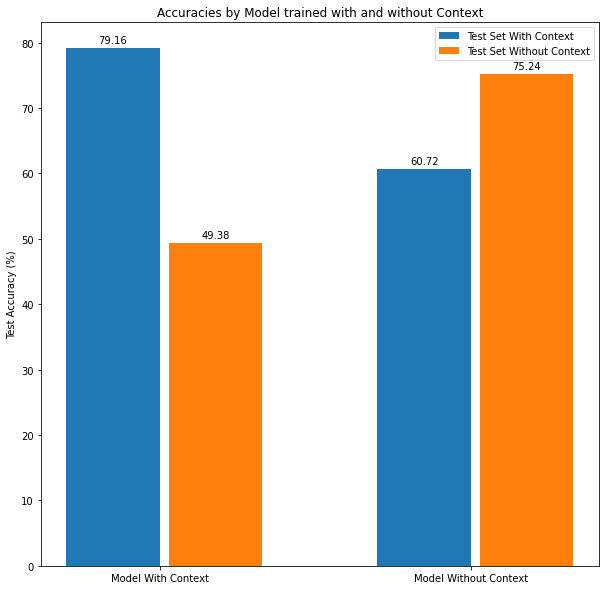

In [37]:
labels = ['Model With Context', 'Model Without Context']
orig_accuracies = [unc_model_uncropped , crp_model_uncropped ]
cropped_accuracies = [unc_model_cropped , crp_model_cropped ]

x = np.arange(len(labels))  # the label locations
width = 0.3 # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, orig_accuracies, width, label='Test Set With Context')
rects2 = ax.bar(x + width/2 + 0.03, cropped_accuracies, width, label='Test Set Without Context')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Accuracies by Model trained with and without Context')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('')
ax.legend()

fig.set_figheight(10)
fig.set_figwidth(10)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()